In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import random


In [2]:
def gini_impurity(y):
    """
    Calculate Gini impurity for an array of class labels.

    Parameters:
    -----------
    y : array-like
        List or array of class labels.

    Returns:
    --------
    gini : float
        Gini impurity value.
    """
    if len(y) == 0:
        return 0

    unique_labels, label_counts = np.unique(y, return_counts=True)
    probabilities = label_counts / len(y)
    gini = 1 - np.sum(np.square(probabilities))

    return gini


In [3]:
def find_best_attribute(X, y):
    """
    Find the best attribute to split the dataset based on Gini impurity.

    Parameters:
    -----------
    X : array-like
        Feature matrix.
    y : array-like
        Class labels.

    Returns:
    --------
    best_attribute : int
        Index of the best attribute for splitting.
    best_gini : float
        Gini impurity value for the best attribute.
    """
    num_attributes = X.shape[1]
    best_attribute, best_gini, attribute_is_nominal = None, float('inf'), None

    for attribute_idx in range(num_attributes):
        attribute_values = X[:, attribute_idx]

        if np.issubdtype(attribute_values.dtype, np.number):
            # Real-valued attribute
            mean_value = np.mean(attribute_values)
            left_mask = attribute_values < mean_value
            right_mask = ~left_mask
            is_nominal = False
        else:
            # Nominal attribute
            unique_values = np.unique(attribute_values)
            left_mask = attribute_values == unique_values[0]
            right_mask = ~left_mask
            is_nominal = True

        left_y, right_y = y[left_mask], y[right_mask]

        # Weighted Gini impurity
        weighted_gini = (len(left_y) * gini_impurity(left_y) + len(right_y) * gini_impurity(right_y)) / len(y)

        if weighted_gini < best_gini:
            best_attribute, best_gini, attribute_is_nominal = attribute_idx, weighted_gini, is_nominal

    return best_attribute, attribute_is_nominal


In [4]:
def split_dataset(X, y, attribute, is_nominal=False):
    """
    Split the dataset based on the given attribute.

    Parameters:
    -----------
    X : array-like
        Feature matrix.
    y : array-like
        Class labels.
    attribute : int
        Index of the attribute to split on.
    is_nominal : bool, optional, default: False
        Whether the attribute is nominal or not.

    Returns:
    --------
    left_X : array-like
        Left feature matrix.
    left_y : array-like
        Left class labels.
    right_X : array-like
        Right feature matrix.
    right_y : array-like
        Right class labels.
    """
    attribute_values = X[:, attribute]

    if is_nominal:
        unique_values = np.unique(attribute_values)
        left_mask = attribute_values == unique_values[0]
    else:
        mean_value = np.mean(attribute_values)
        left_mask = attribute_values < mean_value

    right_mask = ~left_mask

    left_X, left_y = X[left_mask], y[left_mask]
    right_X, right_y = X[right_mask], y[right_mask]

    return left_X, left_y, right_X, right_y


In [5]:
def build_decision_tree(X, y, depth=0, max_depth=None):
    """
    Build the decision tree recursively.

    Parameters:
    -----------
    X : array-like
        Feature matrix.
    y : array-like
        Class labels.
    depth : int, optional, default: 0
        Current depth of the tree.
    max_depth : int, optional, default: None
        Maximum depth of the tree.

    Returns:
    --------
    tree : dict
        Decision tree.
    """
    if len(np.unique(y)) == 1 or (max_depth is not None and depth >= max_depth):
        return {'label': np.argmax(np.bincount(y))}

    best_attribute, attribute_is_nominal = find_best_attribute(X, y)
    left_X, left_y, right_X, right_y = split_dataset(X, y, best_attribute, attribute_is_nominal)

    tree = {
        'attribute': best_attribute,
        'left': build_decision_tree(left_X, left_y, depth + 1, max_depth),
        'right': build_decision_tree(right_X, right_y, depth + 1, max_depth)
    }

    if attribute_is_nominal:
        tree['value'] = X[0, best_attribute]
    else:
        tree['mean_value'] = np.mean(X[:, best_attribute])

    return tree



In [6]:
def classify(tree, instance):
    """
    Classify an instance using the decision tree.

    Parameters:
    -----------
    tree : dict
        Decision tree.
    instance : array-like
        Instance to classify.

    Returns:
    --------
    label : int
        Predicted class label.
    """
    if 'label' in tree:
        return tree['label']

    attribute = tree['attribute']
    attribute_value = instance[attribute]

    if 'mean_value' in tree:
        if attribute_value < tree['mean_value']:
            return classify(tree['left'], instance)
        else:
            return classify(tree['right'], instance)
    else:
        if attribute_value == tree['value']:
            return classify(tree['left'], instance)
        else:
            return classify(tree['right'], instance)


In [7]:
def print_tree(tree, feature_names, depth=0, side=None):
    indent = "  " * depth
    prefix = f"{indent}|---" if depth > 0 else ""

    if 'label' in tree:
        label = tree['label']
        print(f"{prefix}[{side}] (label: {label})")
    else:
        attribute = tree['attribute']
        attribute_name = feature_names[attribute]
        if 'value' in tree:
            value = tree['value']
            print(f"{prefix}[{side}] {attribute_name} == {value}")
        else:
            print(f"{prefix}[{side}] {attribute_name}")
        
        print_tree(tree['left'], feature_names, depth + 1, side='left')
        print_tree(tree['right'], feature_names, depth + 1, side='right')


# Data Pre Processing

In [8]:
iris_file = "iris.tmls"
iris_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris_data = pd.read_csv(iris_file, header=None, names=iris_columns)

# drop first 2 rows and reset index
iris_data = iris_data.iloc[2:].reset_index(drop=True)
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [9]:
wine_file = "wine.tmls"
wine_columns = ['class', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
wine_data = pd.read_csv(wine_file, header=None, names=wine_columns)

# drop first 2 rows and reset index
wine_data = wine_data.iloc[2:].reset_index(drop=True)
wine_data.head()

,class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127,2.8,3.06,.28,2.29,5.64,1.04,3.92,1065,1
1,13.2,1.78,2.14,11.2,100,2.65,2.76,.26,1.28,4.38,1.05,3.4,1050,1
2,13.16,2.36,2.67,18.6,101,2.8,3.24,.3,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.5,16.8,113,3.85,3.49,.24,2.18,7.8,.86,3.45,1480,1
4,13.24,2.59,2.87,21,118,2.8,2.69,.39,1.82,4.32,1.04,2.93,735,1


In [10]:
bc_file = "wdbc.data"
bc_columns = ["id", "diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
bc_data = pd.read_csv(bc_file, header=None, names=bc_columns)

bc_data = bc_data.drop("id", axis=1)
bc_data.head()

,diagnosis,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
def prepare_dataset(df, target_column, test_size=0.3, random_state=42, scale_features=False):
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values

    # Convert to integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    if scale_features:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, label_encoder

In [12]:
iris_X_train, iris_X_test, iris_y_train, iris_y_test, iris_label_encoder = prepare_dataset(iris_data, "class", scale_features=True)
wine_X_train, wine_X_test, wine_y_train, wine_y_test, wine_label_encoder = prepare_dataset(wine_data, "class", scale_features=True)
bc_X_train, bc_X_test, bc_y_train, bc_y_test, bc_label_encoder = prepare_dataset(bc_data, "diagnosis", scale_features=True)

# Decision Tree

In [13]:
iris_tree = build_decision_tree(iris_X_train, iris_y_train)
wine_tree = build_decision_tree(wine_X_train, wine_y_train)
bc_tree = build_decision_tree(bc_X_train, bc_y_train)

In [14]:
def evaluate_tree(tree, X_test, y_test, label_encoder):
    y_pred = [classify(tree, instance) for instance in X_test]
    y_pred = np.array(y_pred)

    # Convert to original labels
    y_test = label_encoder.inverse_transform(y_test)
    y_pred = label_encoder.inverse_transform(y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    matrix = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, matrix

In [15]:
def plot_confusion_matrix(confusion_matrix, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, confusion_matrix[i, j],
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
iris_accuracy, iris_precision, iris_recall, iris_f1, iris_matrix = evaluate_tree(iris_tree, iris_X_test, iris_y_test, iris_label_encoder)

Iris dataset
Accuracy: 0.9555555555555556
Precision: 0.9582539682539684
Recall: 0.9555555555555556
F1: 0.9544001266223487


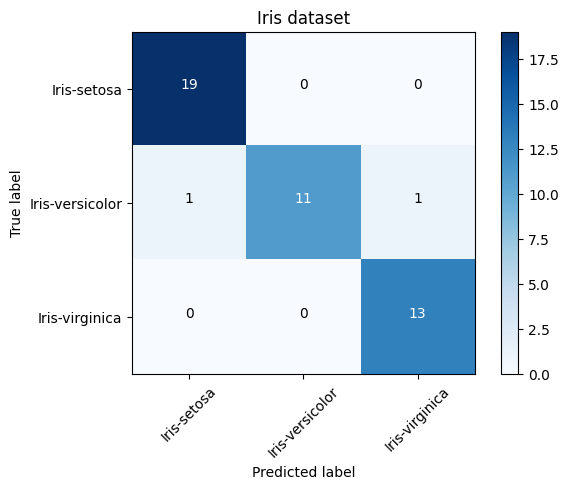

In [17]:
print("Iris dataset")
print(f"Accuracy: {iris_accuracy}")
print(f"Precision: {iris_precision}")
print(f"Recall: {iris_recall}")
print(f"F1: {iris_f1}")
plot_confusion_matrix(iris_matrix, iris_label_encoder.classes_, title='Iris dataset')

## Conclusions: Iris
After scaling the features, and building the trees, the outcomes for the iris dataset seem promising. On all four metrics chosen to evaluate the models, the decision tree for Iris data worked remarkably well

Wine dataset
Accuracy: 0.037037037037037035
Precision: 0.043209876543209874
Recall: 0.037037037037037035
F1: 0.03968253968253969


<AxesSubplot: >

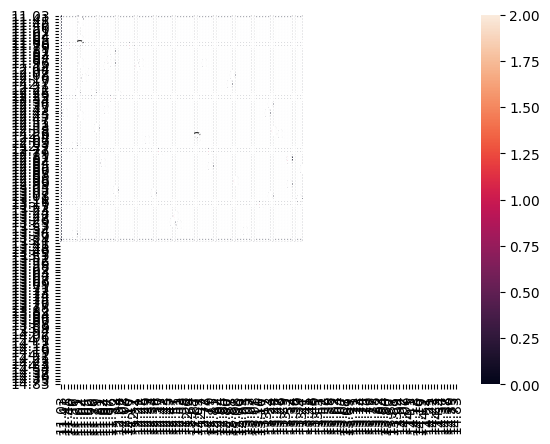

In [18]:
wine_accuracy, wine_precision, wine_recall, wine_f1, wine_matrix = evaluate_tree(wine_tree, wine_X_test, wine_y_test, wine_label_encoder)
print("Wine dataset")
print(f"Accuracy: {wine_accuracy}")
print(f"Precision: {wine_precision}")
print(f"Recall: {wine_recall}")
print(f"F1: {wine_f1}")
sns.heatmap(wine_matrix, annot=True, fmt='d', xticklabels=wine_label_encoder.classes_, yticklabels=wine_label_encoder.classes_)
# plot_confusion_matrix(wine_matrix, wine_label_encoder.classes_, title='Wine dataset')

## Conclusion: Wine
On the other hand, the wine dataset performed horribly, with scores below 1% on all four metrics. The reasons for this may be due to the number of features, and that not all features are relevant to the classification of the wine. This is a problem that can be solved by using feature selection, which will be done in the next section. Before scaling the data, the decision tree performed worse, with a flat 0% score for every metric.

Breast cancer dataset
Accuracy: 0.9532163742690059
Precision: 0.9564320007179072
Recall: 0.9532163742690059
F1: 0.9536113009797221


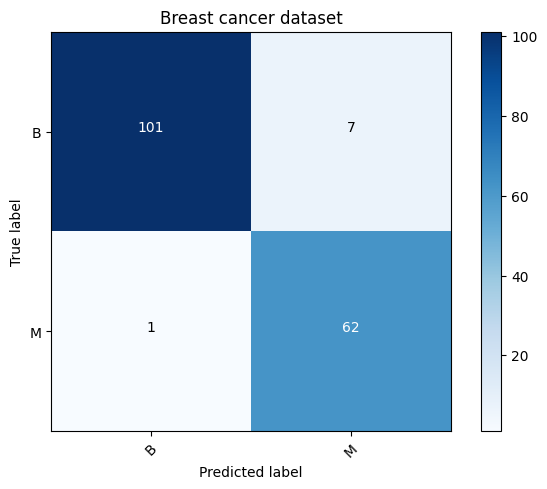

In [19]:
bc_accuracy, bc_precision, bc_recall, bc_f1, bc_matrix = evaluate_tree(bc_tree, bc_X_test, bc_y_test, bc_label_encoder)
print("Breast cancer dataset")
print(f"Accuracy: {bc_accuracy}")
print(f"Precision: {bc_precision}")
print(f"Recall: {bc_recall}")
print(f"F1: {bc_f1}")

plot_confusion_matrix(bc_matrix, bc_label_encoder.classes_, title='Breast cancer dataset')

## Conclusion: Breast Cancer
The breast cancer dataset performed similarly to the Iris dataset, with scores above 90% on all four metrics. This is a good sign, and shows that the decision tree can be used to classify the data. A thing to note is that the dataset had a lot of features, more so than the wine dataset. This may be a reason for the wine dataset performing poorly, as it had a lot of features that were not relevant to the classification of the wine.

# Further Testing

In [20]:
def evaluate_multiple_splits(df, target_column, test_sizes, random_states, scale_features=False):
    results = []

    for test_size in test_sizes:
        for random_state in random_states:
            X_train, X_test, y_train, y_test, label_encoder = prepare_dataset(
                df, target_column, test_size=test_size, random_state=random_state, scale_features=scale_features
            )
            tree = build_decision_tree(X_train, y_train)
            accuracy, precision, recall, f1, confusion_matrix = evaluate_tree(tree, X_test, y_test, label_encoder)
            
            results.append({
                'test_size': test_size,
                'random_state': random_state,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'confusion_matrix': confusion_matrix
            })
    
    return results


In [21]:
def print_results(results, display_conf=False):
    print("Test Size | Random State | Accuracy | Precision | Recall | F1 Score")
    print("-" * 75)
    
    for result in results:
        print(
            f"{result['test_size']:>9.2f} | "
            f"{result['random_state']:>12} | "
            f"{result['accuracy']:.5f} | "
            f"{result['precision']:.5f} | "
            f"{result['recall']:.5f} | "
            f"{result['f1']:.5f}"
        )
        if display_conf:
            print("\nConfusion Matrix")
            sns.heatmap(result['confusion_matrix'], annot=True, cmap='Blues', fmt='d', cbar=False)
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()
        print("-" * 75)

In [22]:
test_sizes = [0.2, 0.3, 0.4]
random_states = [42, random.randint(1,200), random.randint(1,200)]

iris_results = evaluate_multiple_splits(iris_data, "class", test_sizes, random_states, scale_features=True)
wine_results = evaluate_multiple_splits(wine_data, "class", test_sizes, random_states, scale_features=True)
bc_results = evaluate_multiple_splits(bc_data, "diagnosis", test_sizes, random_states, scale_features=True)


## Results
Here, we varied the randomness, as well as the ratio used for the test-train split. Regardless, the Iris tree performed well across all iterationss did the Breast Cancer tree. However, the Wine tree still performed poorly, with scores below 1% on all four metrics, with some iterations getting a perfectly bad score of 0% on all four metrics.

In [23]:
print_results(iris_results)
print_results(wine_results)
print_results(bc_results)

Test Size | Random State | Accuracy | Precision | Recall | F1 Score
---------------------------------------------------------------------------
     0.20 |           42 | 0.93333 | 0.93914 | 0.93333 | 0.93068
---------------------------------------------------------------------------
     0.20 |          141 | 0.90000 | 0.90463 | 0.90000 | 0.90094
---------------------------------------------------------------------------
     0.20 |           98 | 0.80000 | 0.87946 | 0.80000 | 0.80241
---------------------------------------------------------------------------
     0.30 |           42 | 0.95556 | 0.95825 | 0.95556 | 0.95440
---------------------------------------------------------------------------
     0.30 |          141 | 0.91111 | 0.91599 | 0.91111 | 0.91111
---------------------------------------------------------------------------
     0.30 |           98 | 0.88889 | 0.89954 | 0.88889 | 0.88918
---------------------------------------------------------------------------
     0.40 

# Trying Entropy

In [24]:
def entropy(y):
    """
    Calculate the entropy for class labels.

    Parameters:
    -----------
    y : array-like
        Class labels.

    Returns:
    --------
    entropy : float
        Entropy of the class labels.
    """
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

In [25]:
def find_best_attribute(X, y, criterion='gini'):
    num_attributes = X.shape[1]
    best_attribute, best_score, attribute_is_nominal = None, float('inf'), None

    for attribute_idx in range(num_attributes):
        attribute_values = X[:, attribute_idx]

        if np.issubdtype(attribute_values.dtype, np.number):
            # Real-valued attribute
            mean_value = np.mean(attribute_values)
            left_mask = attribute_values < mean_value
            right_mask = ~left_mask
            is_nominal = False
        else:
            # Nominal attribute
            unique_values = np.unique(attribute_values)
            left_mask = attribute_values == unique_values[0]
            right_mask = ~left_mask
            is_nominal = True

        left_y, right_y = y[left_mask], y[right_mask]

        if criterion == 'gini':
            # Weighted Gini impurity
            score = (len(left_y) * gini_impurity(left_y) + len(right_y) * gini_impurity(right_y)) / len(y)
        elif criterion == 'entropy':
            # Weighted information entropy
            score = (len(left_y) * entropy(left_y) + len(right_y) * entropy(right_y)) / len(y)
        else:
            raise ValueError("Invalid criterion specified. Use either 'gini' or 'entropy'.")

        if score < best_score:
            best_attribute, best_score, attribute_is_nominal = attribute_idx, score, is_nominal

    return best_attribute, attribute_is_nominal


In [26]:
def build_decision_tree(X, y, depth=0, max_depth=None, criterion='gini'):
    """
    Build the decision tree recursively.

    Parameters:
    -----------
    X : array-like
        Feature matrix.
    y : array-like
        Class labels.
    depth : int, optional, default: 0
        Current depth of the tree.
    max_depth : int, optional, default: None
        Maximum depth of the tree.

    Returns:
    --------
    tree : dict
        Decision tree.
    """
    if len(np.unique(y)) == 1 or (max_depth is not None and depth >= max_depth):
        return {'label': np.argmax(np.bincount(y))}

    best_attribute, attribute_is_nominal = find_best_attribute(X, y, criterion=criterion)
    left_X, left_y, right_X, right_y = split_dataset(X, y, best_attribute, attribute_is_nominal)

    tree = {
        'attribute': best_attribute,
        'left': build_decision_tree(left_X, left_y, depth + 1, max_depth),
        'right': build_decision_tree(right_X, right_y, depth + 1, max_depth)
    }

    if attribute_is_nominal:
        tree['value'] = X[0, best_attribute]
    else:
        tree['mean_value'] = np.mean(X[:, best_attribute])

    return tree

In [27]:
def evaluate_multiple_splits(df, target_column, test_sizes, random_states, criteria=['gini', 'entropy'], scale_features=False):
    results = []

    for test_size in test_sizes:
        for random_state in random_states:
            for criterion in criteria:
                X_train, X_test, y_train, y_test, label_encoder = prepare_dataset(
                    df, target_column, test_size=test_size, random_state=random_state, scale_features=scale_features
                )
                tree = build_decision_tree(X_train, y_train, criterion=criterion)
                accuracy, precision, recall, f1, confusion_matrix = evaluate_tree(tree, X_test, y_test, label_encoder)
                
                results.append({
                    'test_size': test_size,
                    'random_state': random_state,
                    'criterion': criterion,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'confusion_matrix': confusion_matrix
                })
    
    return results


In [28]:
def print_results(results, display_conf=False):
    print("Test Size | Random State | Criterion | Accuracy | Precision | Recall | F1 Score")
    print("-" * 85)
    
    for result in results:
        print(
            f"{result['test_size']:>9.2f} | "
            f"{result['random_state']:>12} | "
            f"{result['criterion']:>10} | "
            f"{result['accuracy']:.5f} | "
            f"{result['precision']:.5f} | "
            f"{result['recall']:.5f} | "
            f"{result['f1']:.5f}"
        )
        if display_conf:
            print("\nConfusion Matrix")
            sns.heatmap(result['confusion_matrix'], annot=True, cmap='Blues', fmt='d', cbar=False)
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()
        print("-" * 85)


In [29]:
iris_results = evaluate_multiple_splits(iris_data, "class", test_sizes, random_states, scale_features=True)
wine_results = evaluate_multiple_splits(wine_data, "class", test_sizes, random_states, scale_features=True)
bc_results = evaluate_multiple_splits(bc_data, "diagnosis", test_sizes, random_states, scale_features=True)     

## Results :: With Entropy
Here, I added iterations where the criterion used in the trees were entropy instead of Gini. For Iris and Breast Cancer, the trees performed similarly between both Entrop and Gini, with Gini better in some cases, whilst being equal in others. For the Wine dataset, the trees still performed horrendously, and when the scores are not 0%, Gini performed better than Entropy.

In [35]:
print_results(iris_results)
print_results(wine_results)
print_results(bc_results)

Test Size | Random State | Criterion | Accuracy | Precision | Recall | F1 Score
-------------------------------------------------------------------------------------
     0.20 |           42 |       gini | 0.93333 | 0.93914 | 0.93333 | 0.93068
-------------------------------------------------------------------------------------
     0.20 |           42 |    entropy | 0.93333 | 0.93914 | 0.93333 | 0.93068
-------------------------------------------------------------------------------------
     0.20 |          141 |       gini | 0.90000 | 0.90463 | 0.90000 | 0.90094
-------------------------------------------------------------------------------------
     0.20 |          141 |    entropy | 0.90000 | 0.90463 | 0.90000 | 0.90094
-------------------------------------------------------------------------------------
     0.20 |           98 |       gini | 0.80000 | 0.87946 | 0.80000 | 0.80241
-------------------------------------------------------------------------------------
     0.20 |   

## Wine Data, with correlation

In [30]:
modded_wine_data = wine_data.apply(pd.to_numeric, errors='coerce')
corr_matrix = modded_wine_data.corr()
target_corr = corr_matrix["class"].sort_values(ascending=False)
threshold = 0.2
selected_features = target_corr[abs(target_corr) > threshold]
print(selected_features)

class                           1.000000
od280/od315_of_diluted_wines    0.643720
proanthocyanins                 0.546364
magnesium                       0.289101
alcalinity_of_ash               0.270798
total_phenols                   0.236815
malic_acid                      0.211545
ash                            -0.310235
proline                        -0.328222
Name: class, dtype: float64


In [31]:
modded_wine_data = wine_data[selected_features.index]
modded_wine_data.head()

,class,od280/od315_of_diluted_wines,proanthocyanins,magnesium,alcalinity_of_ash,total_phenols,malic_acid,ash,proline
0,14.23,1065,5.64,2.8,127,3.06,2.43,15.6,1
1,13.2,1050,4.38,2.65,100,2.76,2.14,11.2,1
2,13.16,1185,5.68,2.8,101,3.24,2.67,18.6,1
3,14.37,1480,7.8,3.85,113,3.49,2.5,16.8,1
4,13.24,735,4.32,2.8,118,2.69,2.87,21,1


In [32]:
modded_wine_results = evaluate_multiple_splits(modded_wine_data, "class", test_sizes, random_states, scale_features=True)
print_results(modded_wine_results)

Test Size | Random State | Criterion | Accuracy | Precision | Recall | F1 Score
-------------------------------------------------------------------------------------
     0.20 |           42 |       gini | 0.00000 | 0.00000 | 0.00000 | 0.00000
-------------------------------------------------------------------------------------
     0.20 |           42 |    entropy | 0.05556 | 0.08333 | 0.05556 | 0.06667
-------------------------------------------------------------------------------------
     0.20 |          141 |       gini | 0.00000 | 0.00000 | 0.00000 | 0.00000
-------------------------------------------------------------------------------------
     0.20 |          141 |    entropy | 0.00000 | 0.00000 | 0.00000 | 0.00000
-------------------------------------------------------------------------------------
     0.20 |           98 |       gini | 0.00000 | 0.00000 | 0.00000 | 0.00000
-------------------------------------------------------------------------------------
     0.20 |   

## Results :: With Entropy and Correlation
Here, instead of using the full wine dataset, I selected less features, choosing only the ones with an absolute correlation of 0.2 or higher. However, the results were still horrendous. Even with a higher treshhold of 0.5, the results were still bad. This shows that the wine dataset is not a good dataset to use for decision trees.

In [36]:
modded_wine_data = wine_data.apply(pd.to_numeric, errors='coerce')
corr_matrix = modded_wine_data.corr()
target_corr = corr_matrix["class"].sort_values(ascending=False)
threshold = 0.5
selected_features = target_corr[abs(target_corr) > threshold]
print(selected_features)

modded_wine_data = wine_data[selected_features.index]
modded_wine_data.head()

class                           1.000000
od280/od315_of_diluted_wines    0.643720
proanthocyanins                 0.546364
Name: class, dtype: float64


,class,od280/od315_of_diluted_wines,proanthocyanins
0,14.23,1065,5.64
1,13.2,1050,4.38
2,13.16,1185,5.68
3,14.37,1480,7.8
4,13.24,735,4.32


In [37]:
modded_wine_results = evaluate_multiple_splits(modded_wine_data, "class", test_sizes, random_states, scale_features=True)
print_results(modded_wine_results)

Test Size | Random State | Criterion | Accuracy | Precision | Recall | F1 Score
-------------------------------------------------------------------------------------
     0.20 |           42 |       gini | 0.02778 | 0.08333 | 0.02778 | 0.04167
-------------------------------------------------------------------------------------
     0.20 |           42 |    entropy | 0.02778 | 0.08333 | 0.02778 | 0.04167
-------------------------------------------------------------------------------------
     0.20 |          141 |       gini | 0.02778 | 0.00694 | 0.02778 | 0.01111
-------------------------------------------------------------------------------------
     0.20 |          141 |    entropy | 0.02778 | 0.00694 | 0.02778 | 0.01111
-------------------------------------------------------------------------------------
     0.20 |           98 |       gini | 0.00000 | 0.00000 | 0.00000 | 0.00000
-------------------------------------------------------------------------------------
     0.20 |   